In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Так как у меня были проблемы с работой с таким большим датасетом в Колабе, в данной работе я беру выборку из 100К наблюдений.

In [4]:
data = pd.read_csv('/content/drive/MyDrive/RecSys/data.csv').sample(500000).drop(['campaign_clicks'], axis=1)
data.head()

,date_time,zone_id,banner_id,oaid_hash,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
15266288,2021-09-29 17:44:01.000000,50,1067,4892413428158631937,0,5,1067,0.001,0.647200,-3.592423,494,0.010,0.051944,-4.281153,1,0
5747841,2021-09-26 22:05:20.000000,23,2,3409549229272197463,0,0,2,0.014,0.014274,-3.714874,21,0.014,0.014514,-3.824778,1,0
3100816,2021-09-26 09:11:45.000000,112,671,4779007219932892419,2,0,671,0.015,0.084447,-1.963349,4,0.019,0.116303,-2.525730,1,0
13939857,2021-10-01 08:53:01.000000,45,609,1871169216674498606,2,7,609,0.006,0.023675,-4.027725,14249356,85.000,0.002435,-3.334903,1,0
6808919,2021-09-30 11:36:12.000000,45,646,4523409292023800345,4,7,646,0.050,0.210001,-2.249737,663,0.050,0.281339,-2.528364,1,0


### Анализ:

Общее описание данных:
              zone_id      banner_id     oaid_hash          os_id  \
count  100000.000000  100000.000000  1.000000e+05  100000.000000   
mean       81.614120     381.634150  4.609545e+18       1.838520   
std       161.902653     396.246025  2.661648e+18       1.529231   
min         0.000000       0.000000  7.036755e+13       0.000000   
25%        14.000000      52.000000  2.306608e+18       1.000000   
50%        19.000000     218.000000  4.613138e+18       2.000000   
75%        60.000000     613.000000  6.916892e+18       3.000000   
max      3268.000000    1447.000000  9.223130e+18       8.000000   

          country_id    banner_id0          rate0             g0  \
count  100000.000000  1.000000e+05  100000.000000  100000.000000   
mean        4.333280  6.520131e+05       0.189629       0.768187   
std         4.321524  2.597044e+06       2.623631      16.959630   
min         0.000000  0.000000e+00       0.000100       0.000000   
25%         0.000000  7

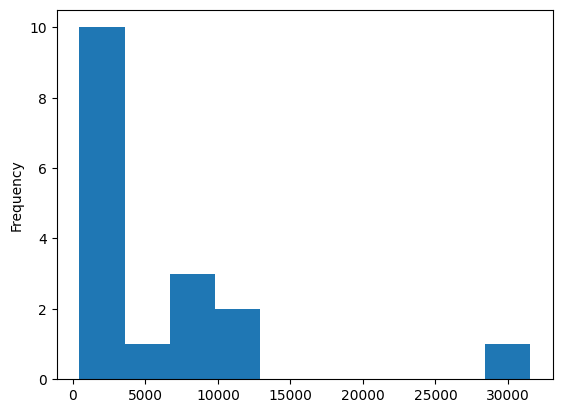

Диаграмма зависимости количество записей от страны:
 Axes(0.125,0.11;0.775x0.77) None 


Количество записей в зависимости от страны:
 0     31541
5     12099
6      9989
7      9446
3      8470
1      8445
15     3772
12     3018
9      2733
4      2477
10     2227
11     1345
8      1325
13     1216
14      931
16      513
2       453
Name: country_id, dtype: int64 




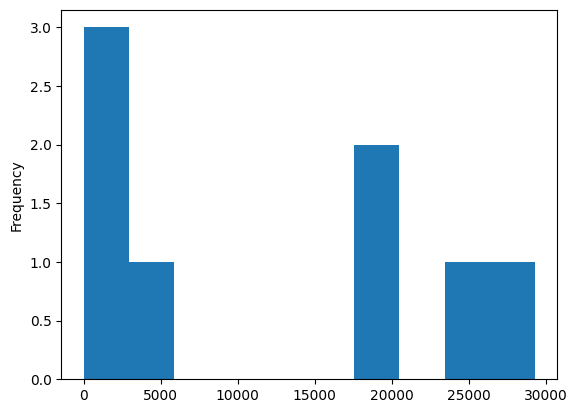

Диаграмма зависимости количество записей от ОС:
 Axes(0.125,0.11;0.775x0.77) None 




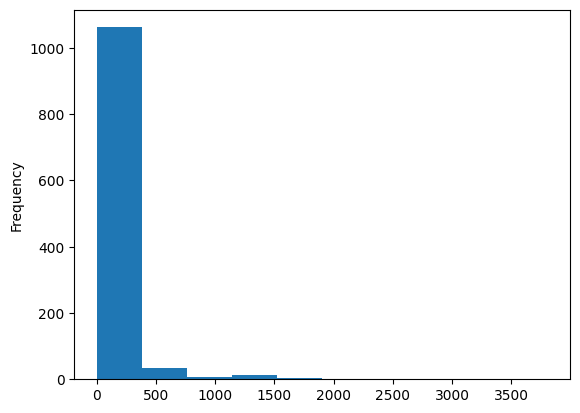

Частота встречающихся баннеров Axes(0.125,0.11;0.775x0.77) None 




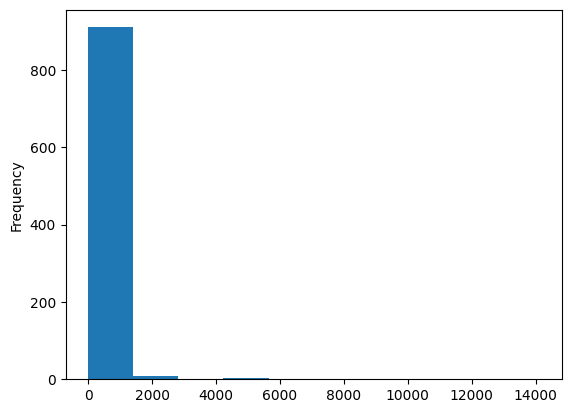

Частота используемых зон Axes(0.125,0.11;0.775x0.77) None 




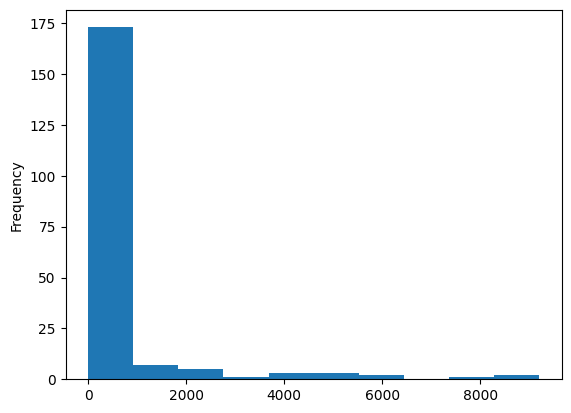

rate0 Axes(0.125,0.11;0.775x0.77) None 




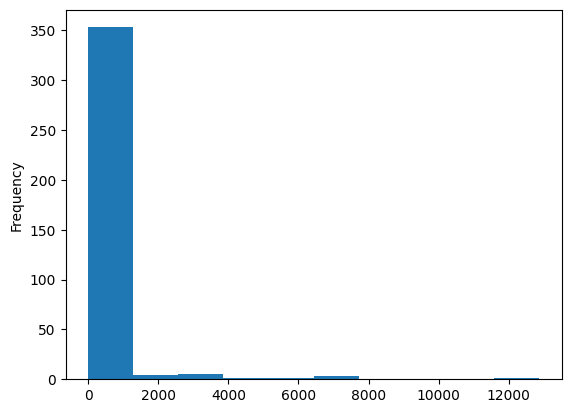

rate1 Axes(0.125,0.11;0.775x0.77) None 


Количество записей в зависимости от ОС:
 2    29282
0    24448
1    19906
4    18849
3     4800
6     1984
5      722
8        9
Name: os_id, dtype: int64 


Количество нулевых значений: 357


In [12]:
def analysis(data: pd.DataFrame):
    print('Общее описание данных:\n', data.describe(), '\n\n')
    print('Количество повторяющихся значений: ', len(data[data.duplicated()]), '\n\n')
    print('Диаграмма зависимости количество записей от страны:\n', data.country_id.value_counts().plot(kind='hist'), plt.show(), '\n\n')
    print('Количество записей в зависимости от страны:\n', data.country_id.value_counts(), '\n\n')
    print('Диаграмма зависимости количество записей от ОС:\n', data.os_id.value_counts().plot(kind='hist'), plt.show(),'\n\n')
    print('Частота встречающихся баннеров', data.banner_id.value_counts().plot(kind='hist'), plt.show(),'\n\n')
    print('Частота используемых зон', data.zone_id.value_counts().plot(kind='hist'), plt.show(),'\n\n')

    print('rate0', data.rate0.value_counts().plot(kind='hist'), plt.show(),'\n\n')
    print('rate1', data.rate1.value_counts().plot(kind='hist'), plt.show(),'\n\n')

    print('Количество записей в зависимости от ОС:\n', data.os_id.value_counts(), '\n\n')
    print('Количество нулевых значений:', data.isna().sum().sum())
analysis(data)

Есть нулевые значения - их нужно удалить.
Среднее стоимости 1 клика установленная рекламодателем для banner_id1 больше в 10 раз, чем для banner_id0, при этом у баннера 0 больше "дорогих кликов".

In [5]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    categ = [ 'zone_id', 'banner_id', 'oaid_hash' , 'os_id', 'country_id', 'hour', 'month', 'day']
    data = data.drop(['impressions'], axis=1)
    data['hour'], data['month'], data['day'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S.%f').dt.hour, \
                                              pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S.%f').dt.month, \
                                              pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S.%f').dt.day
    data.drop_duplicates(inplace=True)
    condition_zone_id = data['zone_id'].value_counts()
    new_zone = condition_zone_id[condition_zone_id <= 3000].index
    data['zone_id'] = data['zone_id'].apply(lambda x: 0 if x in new_zone else x)
    for col in categ:
        if col == 'os_id':
            data.loc[data['os_id'] > 7, 'os_id'] = 7
        elif col != "oaid_hash":
            column = data[col].value_counts()
            mask_obs = column[column < column.sum() * 0.0001].index
            mask = data[col].isin(mask_obs)
            data.loc[mask, col] = 0
    for col in categ:
        data[col], _ = pd.factorize(data[col])
    data = data.dropna()
    oaid_hash_vc = data.oaid_hash.value_counts()
    oaid_hash_to_change = oaid_hash_vc[oaid_hash_vc <= 2].index
    data.loc[data.oaid_hash.isin(oaid_hash_to_change), "oaid_hash"] = -100
    return data

data = feature_engineering(data)
data.tail()

,date_time,zone_id,banner_id,oaid_hash,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,clicks,hour,month,day
6666720,2021-09-28 13:32:50.000000,3,23,-100,3,2,10917502,0.047,0.000000,0.000000,22,0.004,0.003680,-4.321483,0,6,0,5
13243343,2021-10-01 07:46:09.000000,7,3,-100,3,4,609,0.006,0.034275,-3.830050,597,0.002,0.066310,-3.318132,0,21,1,2
4130156,2021-09-29 21:26:04.000000,1,180,-100,0,5,315,0.015,0.125759,-3.851988,302,0.011,0.107973,-3.606822,0,7,0,0
6086881,2021-09-27 13:32:44.000000,1,150,-100,2,4,620,0.050,0.084292,-2.981164,649,0.050,0.085919,-2.981164,0,6,0,6
12969037,2021-09-26 16:18:08.000000,1,7,-100,2,2,39,0.006,0.032201,-3.942691,96,0.006,0.033277,-4.001179,0,20,0,1


In [6]:
data.sort_values(by="date_time", inplace=True)

Тестируем на последнем дне.

Оставляем только строки, где banner_id == banner_id0

Отдельный тестовый набор, где banner_id == banner_id1

In [41]:
# разделим данные на тренировочную и тестовую выборку

X_train, X_test = data[data.date_time < '2021-10-02'].copy(), data[data.date_time >= '2021-10-02'].copy()

X_test = X_test[X_test["banner_id"] == X_test["banner_id0"]]
X_test, y_test = X_test.drop(['clicks'], axis=1), X_test['clicks']
X_train, y_train = X_train.drop(['clicks'], axis=1), X_train['clicks']

print(X_test.shape, y_test.shape)

X_test1 = X_test.copy()
y_test1 = y_test.copy()
X_test1["banner_id"] = X_test1["banner_id1"]

(1047, 17) (1047,)


In [42]:
X_train.drop(["date_time"], axis=1, inplace=True)
X_test.drop(["date_time"], axis=1, inplace=True)
X_test1.drop(["date_time"], axis=1, inplace=True)

### Обучение модели:

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

In [14]:
def create_train_model(X_train, y_train):
    return LogisticRegression(max_iter=100, solver='liblinear', C=0.01)

model = create_train_model(X_train, y_train)
model.fit(X_train, y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [15]:
y_model = model.predict_proba(X_test)[:, 1]
print(f"logLoss = {log_loss(y_test, y_model):.4f}, ROC AUC = {roc_auc_score(y_test, y_model):.4f}")

logLoss = 0.1366, ROC AUC = 0.6614


### CIPS:

Найдем, что одна нормальная случайная величина $X$ больше другой случайной величины $Y$. Применим свойства.

$P(X > Y) = P(X - Y > 0) = 1 - P(X - Y <= 0) = 1 - F_{X - Y}(0)$

Так как случайные величины независимы, то их разность тоже имеет нормальное распределение.

Тогда $(X - Y)  \sim  N(E_X - E_Y, D_X + D_Y )$

In [16]:
from scipy.stats import norm
from scipy.special import logit
import numpy as np

In [50]:
def calc_prob(coef_summ0, coef_summ1, g0, g1):
    mean = coef_summ0 - coef_summ1
    std = np.sqrt(g0 ** 2 + g1 ** 2) + 1e-9
    return 1 - norm.cdf(0, loc=mean, scale=std)

In [51]:
pi0 = calc_prob(
    X_test.coeff_sum0,
    X_test.coeff_sum1,
    X_test.g0,
    X_test.g1
)

y_pred = model.predict_proba(X_test)[:, 1]
y_pred1 = model.predict_proba(X_test1)[:, 1]
coeff_sum0_new = logit(y_pred)
coeff_sum1_new = logit(y_pred1)

In [ ]:
pi1 = calc_prob(
    coeff_sum0_new,
    coeff_sum1_new,
    X_test.g0,
    X_test.g1
)

In [58]:
lambda_val = 10

cips = np.mean(y_test * np.minimum(pi1/ (pi0 + 1e-9), lambda_val))
print(f'CIPS = {cips}')

CIPS = 0.1470874087393542
